# QuantumSim - Quantum Fourier Transform

Author: Nico Kuijpers<br>
Date: May 11, 2024

## Introduction
The quantum Fourier transform (QFT) is the quantum analogue of the discrete Fourier transform. 
QFT is part of many quantum algorithms including, as we will see later, Shor's algorithm.

QFT can be implemented using Hadamard gates and phase gates.

In this Jupyter notebook we create quantum circuits for QFT and the inverse QFT using QuantumSim. An intuitive explanation 
of quantum Fourier transform is presented in the Qiskit notebook below.

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb

The code introduced in this notebook is adapted from this notebook and is also included in QuantumSim in class QuantumFourier, see

https://github.com/nicokuijpers/QuantumSim/blob/main/quantumsim.py

In [1]:
from quantumsim import *

## Definition of QFT
QFT is the same as the classical Discrete Fourier Transform (DFT) applied to the vector of amplitudes of a quantum state with
length $N = 2^n$.

The classical Fourier transform maps vector $(x_0, x_1, \ldots, x_{N-1}) \in \mathbb{C}^N$ to vector $(y_0, y_1, \ldots, y_{N-1}) \in \mathbb{C}^N$
according to

$y_k = \frac{1}{\sqrt{N}} \sum_{n=0}^{N-1} x_n \omega_N^{-nk}$, for $k = 0, 1, 2, \ldots, N-1$,

where $\omega_N = e^{\frac{2 \pi i}{N}}$ and $\omega^n_N$ is an $N$-th *root of unity*, i.e., if $z = \omega^n_N$ then $z^N = 1$.

In a similar fashion, the quantum Fourier transform maps quantum state $|x\rangle = \sum_{i=0}^{N-1} x_i |i\rangle$ to quantum state
$\sum_{i=0}^{N-1} y_i |i\rangle$ according to

$y_k = \frac{1}{\sqrt{N}} \sum_{n=0}^{N-1} x_n \omega_N^{nk}$, for $k = 0, 1, 2, \ldots, N-1$.

Since $\omega^n_N$ is a rotation, the inverse quantum Fourier transform is similar, but with

$x_n = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} y_k \omega_N^{-nk}$, for $n = 0, 1, 2, \ldots, N-1$.

If $|x\rangle$ is a basis state, then the quantum Fourier transform can also be expressed as the map

$\text{QFT} : |x\rangle \mapsto \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} \omega_N^{x k} |k\rangle$.

QFT can also be expressed as a unitary matrix $U_{\text{QFT}}$, where

$U_{\text{QFT}} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{j k} |k\rangle\langle j|$.



## General QFT Function
Below we define helper functions *qft_rotations()* and *swap_registers()*, and function *create_qft_circuit()*.
By calling the latter with parameter $N$, a quantum circuit of $N$ qubits will be created for the Quantum Fourier Transform.

In [2]:
def qft_rotations(circuit:Circuit, n):
    if n == 0:
        return circuit
    
    # Apply Hadamard operation to the most significant qubit
    circuit.hadamard(n-1) 
    for qubit in range(n-1):
        # For each less significant qubit, a controlled rotation
        # is applied with a smaller angle.
        circuit.controlled_phase(-np.pi/2**(n-1-qubit), qubit, n-1)
    
    # Recursive function call with n-1
    qft_rotations(circuit, n-1)

def swap_registers(circuit:Circuit):
    for qubit in range(circuit.N//2):
        circuit.swap(qubit, circuit.N-qubit-1)
    return circuit

def create_qft_circuit(N):
    circuit = Circuit(N)
    qft_rotations(circuit, N)
    swap_registers(circuit)
    return circuit

In [3]:
circuit = create_qft_circuit(4)

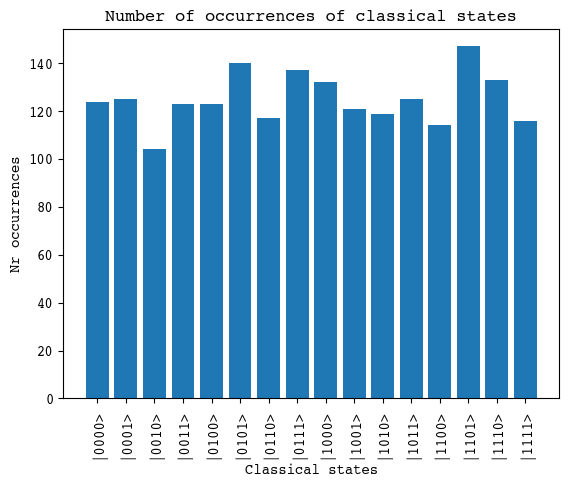

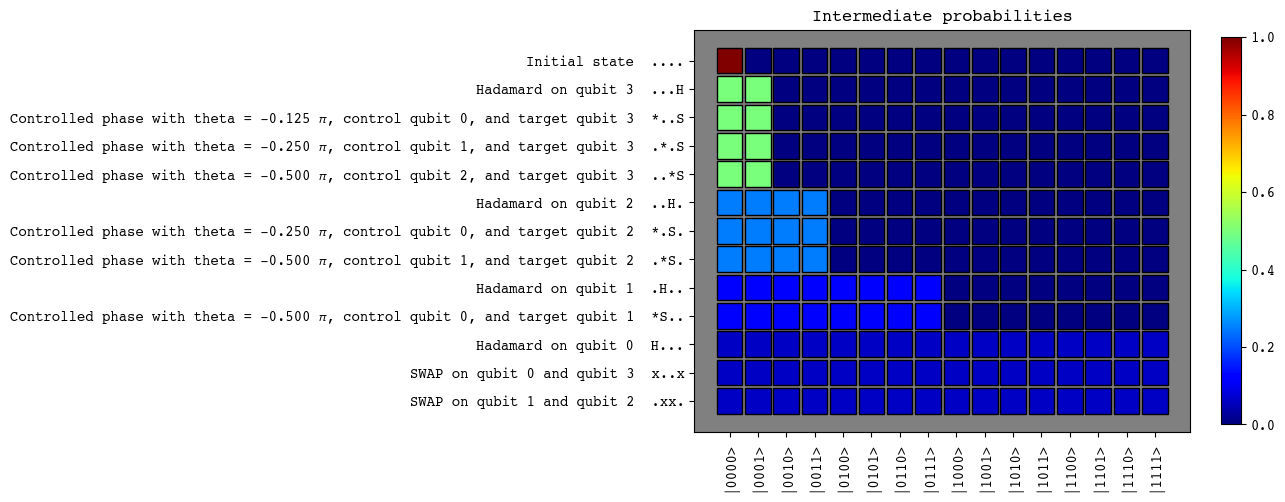

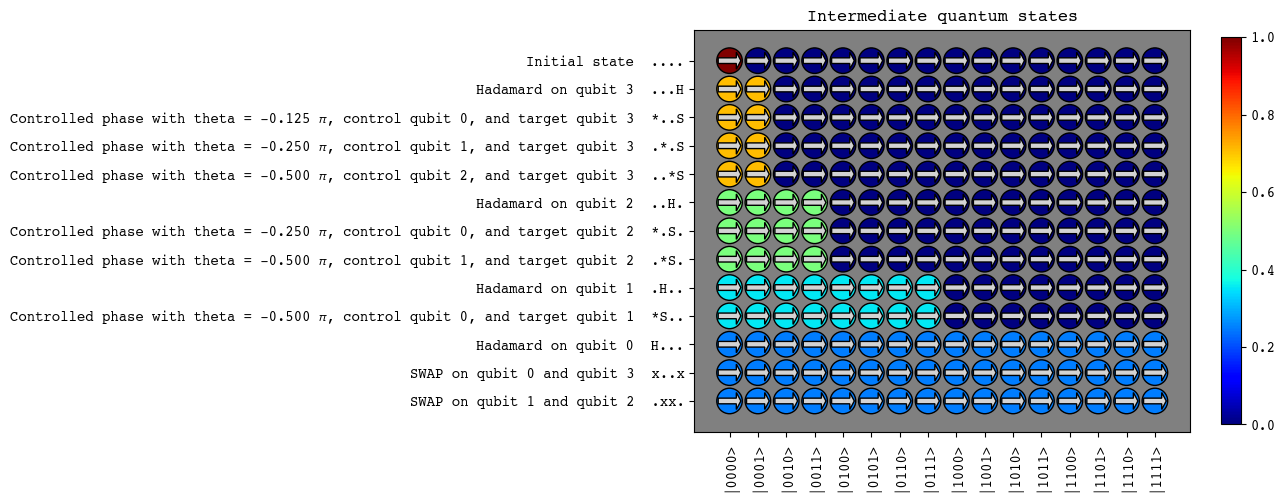

In [4]:
result = QuantumUtil.run_circuit(circuit,2000)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_probabilities(circuit)
QuantumUtil.show_all_intermediate_states(circuit)

## Inverse Quantum Fourier Transform
A circuit for the inverse QFT can be created by reversing the unitary operations of a QFT circuit.

Below, a circuit composed of $3$ qubits is created. First, the qubits are brought into Fourier state $|\tilde{5}\rangle$. Next, a QFT circuit of $3$ qubits is created. The inverse of this circuit is an inverse QFT circuit of $3$ qubits and is appended to the first $3$-qubit circuit. After applying inverse QFT and measuring, the resulting classical state will the binary represention of $5$, which is $|101\rangle$.

In [5]:
nr_qubits = 3
number = 5
circuit = Circuit(nr_qubits)
for qubit in range(nr_qubits):
    circuit.hadamard(qubit)
circuit.phase(number*np.pi/4,0)
circuit.phase(number*np.pi/2,1)
circuit.phase(number*np.pi,2)

qft_circuit = create_qft_circuit(nr_qubits)
iqft_circuit = qft_circuit.create_inverse_circuit()
circuit.append_circuit(iqft_circuit)

# Note that the most signifact qubit is qubit nr_qubits-1. To obtain a classical state 
# representing the binary representation of number, the registers are swapped again.
swap_registers(circuit)

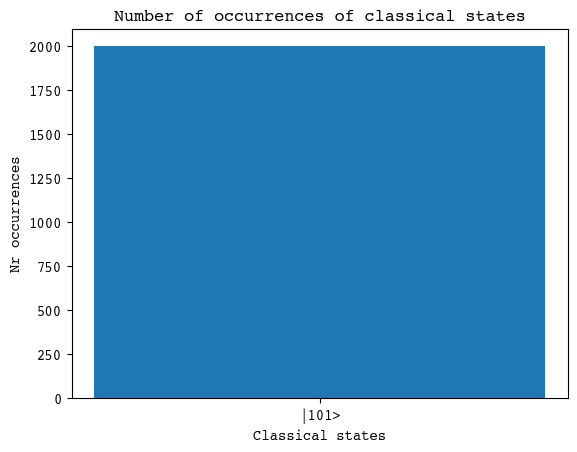

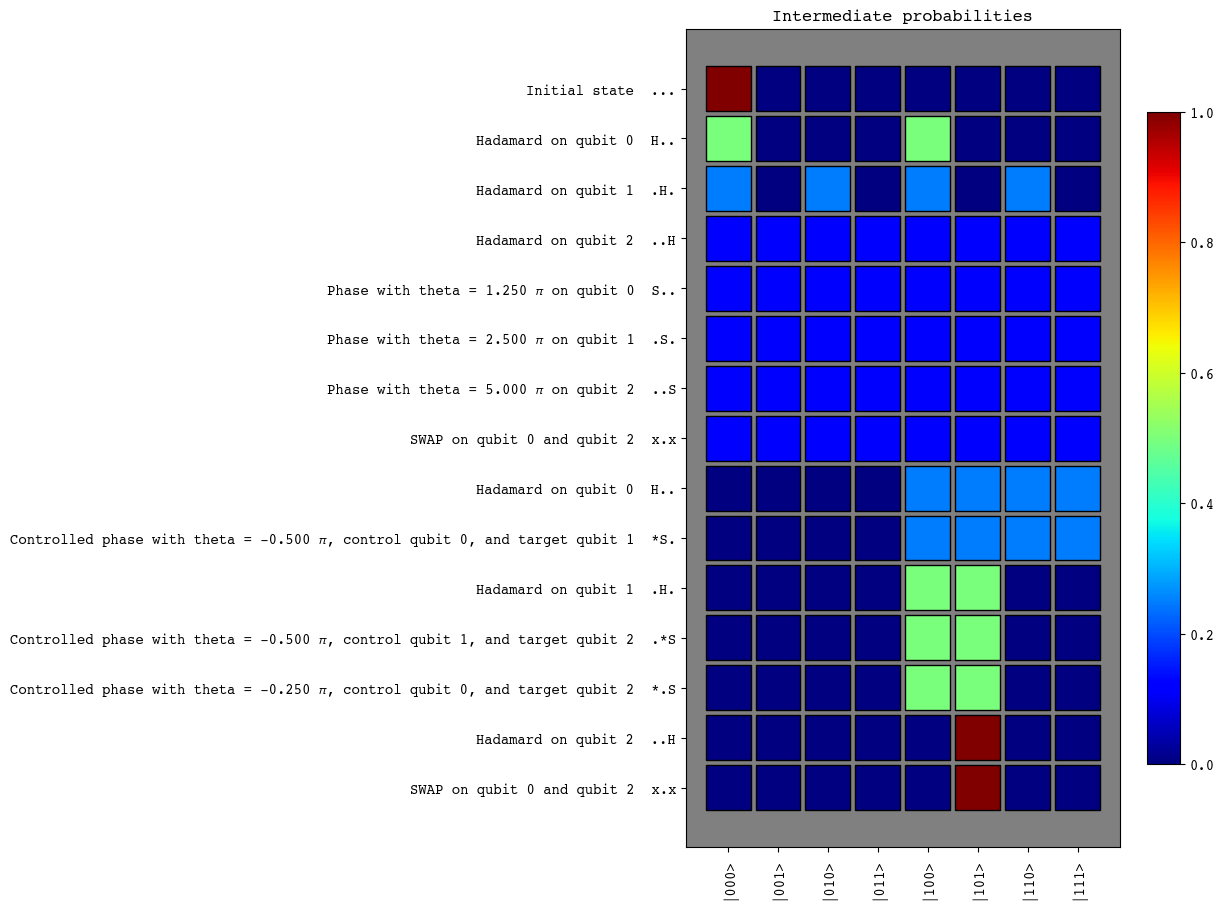

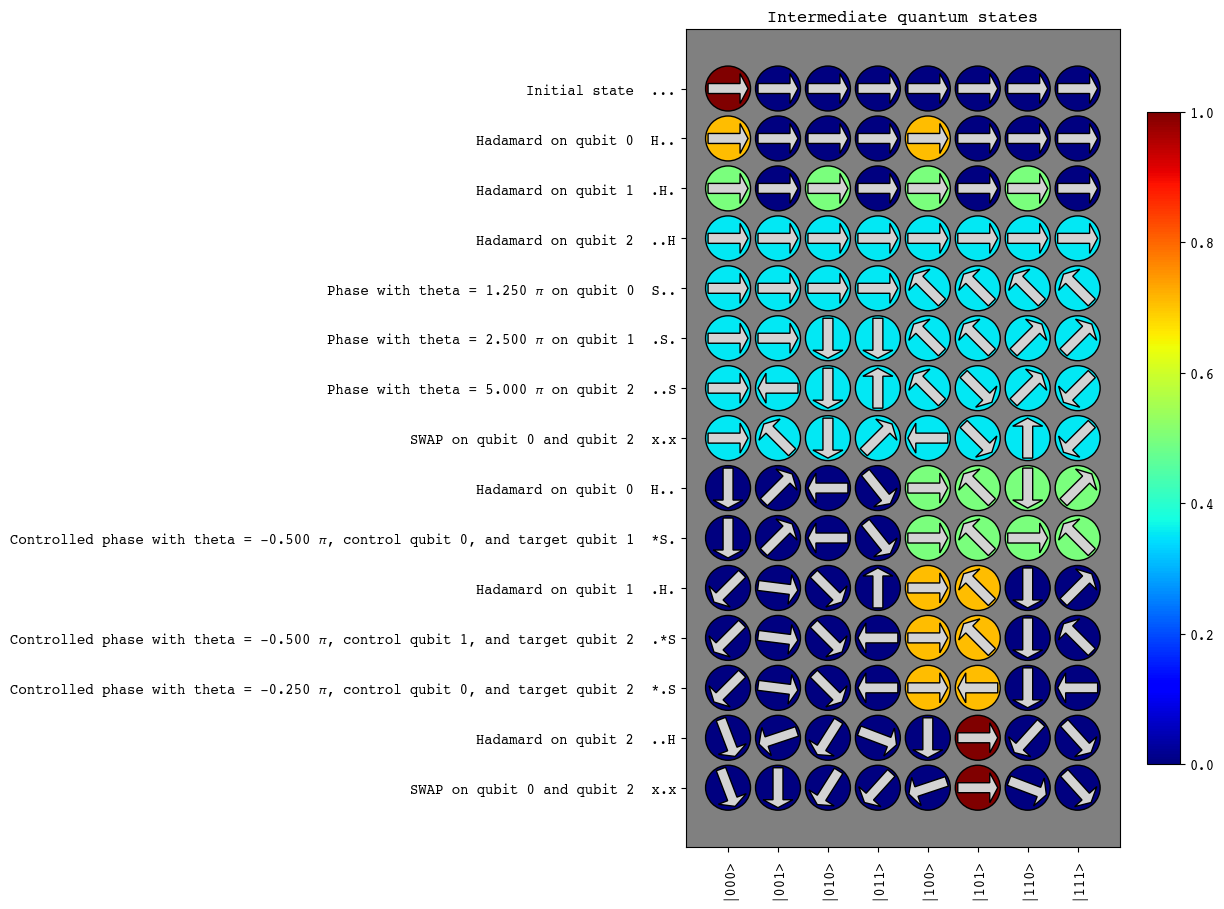

In [6]:
result = QuantumUtil.run_circuit(circuit,2000)
QuantumUtil.histogram_of_classical_states(result)
QuantumUtil.show_all_probabilities(circuit)
QuantumUtil.show_all_intermediate_states(circuit)

## QFT and inverse QFT in QuantumSim
In Python program *quantumsim.py* a class QuantumFourier is defined with function *create_qft_circuit()* to create a QFT circuit and function
*create_iqft_circuit()* to create an inverse QFT circuit. The function *swap_registers()* is implemented as a method of class Circuit in *quantumsim.py*.

Below, we define a function to generate an example circuit using QuantumSim. A circuit composed of $N$ qubits is created. First, the qubits are brought into Fourier state $|\tilde{n}\rangle$ for $0 \leq n < 2^N$. Next, an inverse QFT circuit of $N$ qubits is created. This circuit is appended to the first $N$-qubit circuit. After applying inverse QFT and measuring, the resulting classical state will the binary represention of $n$.

In [7]:
def example_qft(nr_qubits, number, nr_runs):
    circuit = Circuit(nr_qubits)
    for qubit in range(nr_qubits):
        circuit.hadamard(qubit)
    divisor = 2**(nr_qubits-1)
    for qubit in range(nr_qubits):
        circuit.phase(number*np.pi/divisor, qubit)
        divisor /= 2

    iqft_circuit = QuantumFourier.create_iqft_circuit(nr_qubits, swap_registers=True)
    circuit.append_circuit(iqft_circuit)

    # Note that the most signifact qubit is qubit N-1. To obtain a classical state 
    # representing the binary representation of number, the registers are swapped again.
    circuit.swap_registers()

    result = QuantumUtil.run_circuit(circuit, nr_runs)
    QuantumUtil.histogram_of_classical_states(result)
    QuantumUtil.show_all_probabilities(circuit)
    QuantumUtil.show_all_intermediate_states(circuit)

Below, we create a QFT circuit with just one qubit. In this circuit, the Hadamard gate is applied to the qubit. 

For a mathematical derivation of the 1-qubit GFT, we refer to the Qiskit notebook below.

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-fourier-transform.ipynb

In [8]:
circuit = QuantumFourier.create_qft_circuit(1)
circuit.print_circuit()

Hadamard on qubit 0


Below, we create and run an example circuit with just one qubit and number $1$.

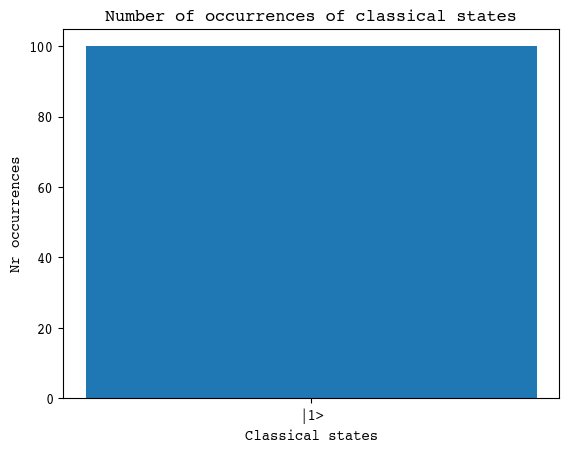

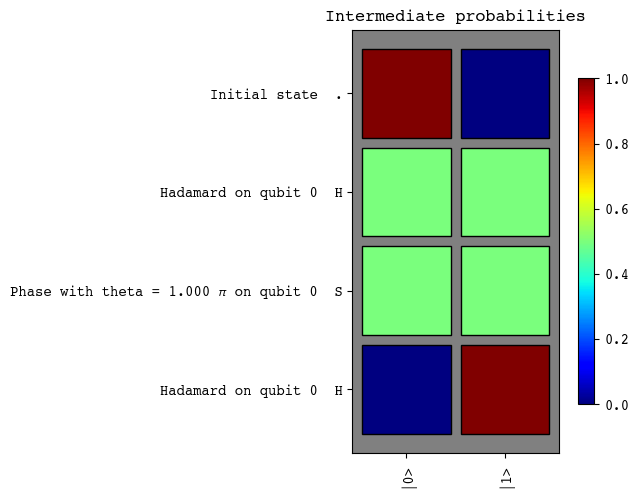

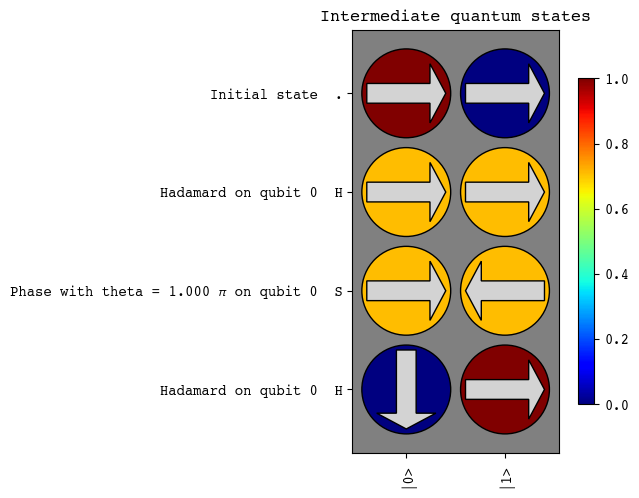

In [9]:
example_qft(1, 1, 100)

Below, a circuit composed of $3$ qubits is created. As before, the qubits are brought into Fourier state $|\tilde{5}\rangle$ and an inverse QFT circuit of $3$ qubits is created. The inverse QFT circuit is appended to the first $3$-qubit circuit. After applying inverse QFT and measuring, the resulting classical state will the binary represention of $5$, which is $|101\rangle$.

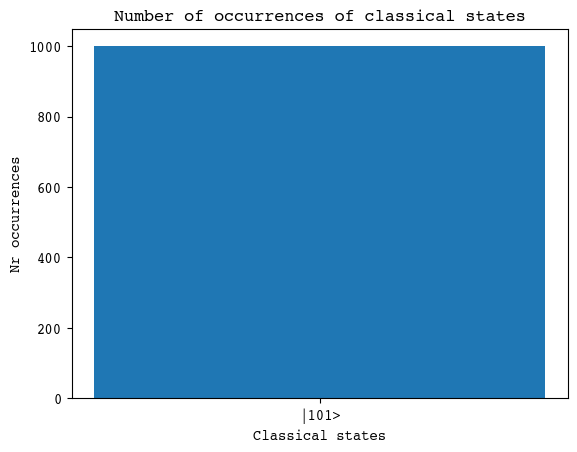

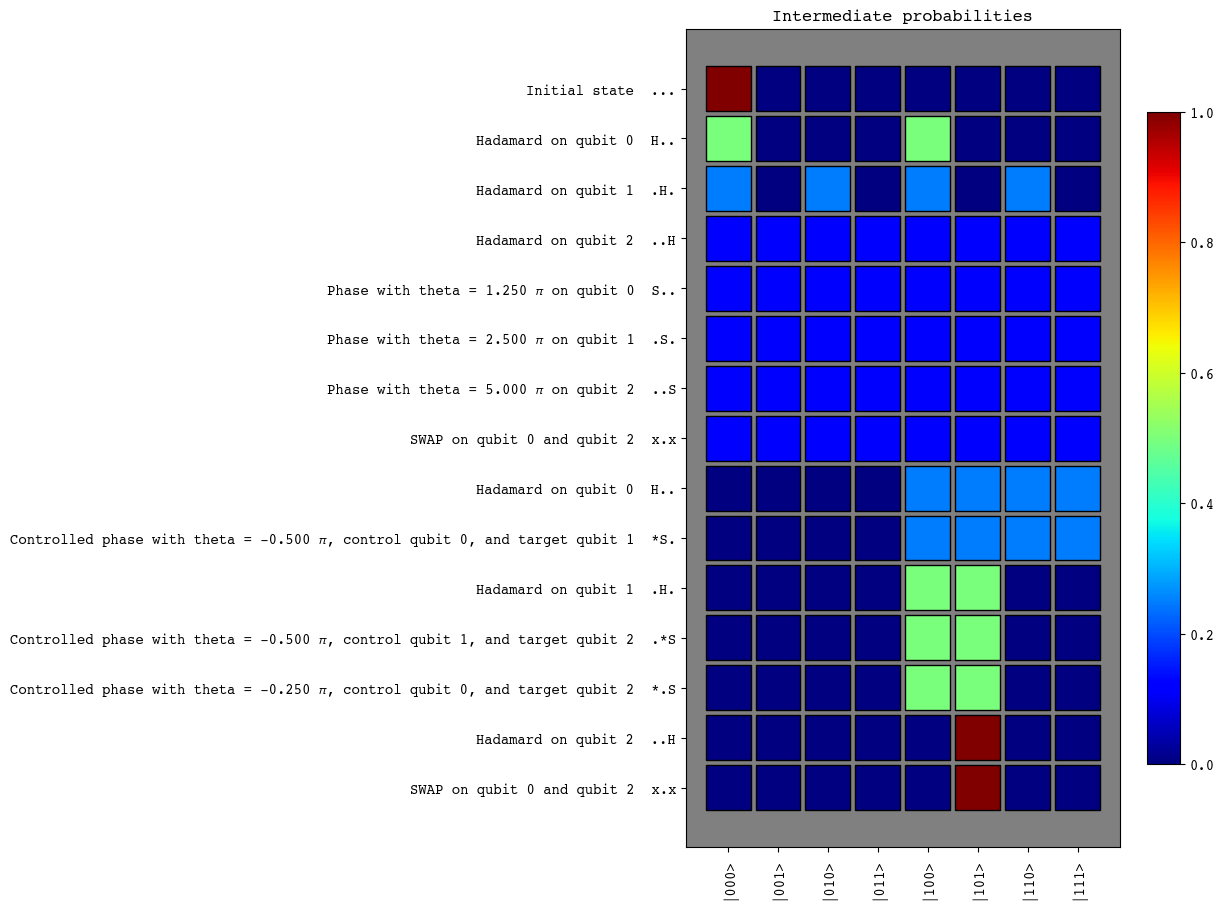

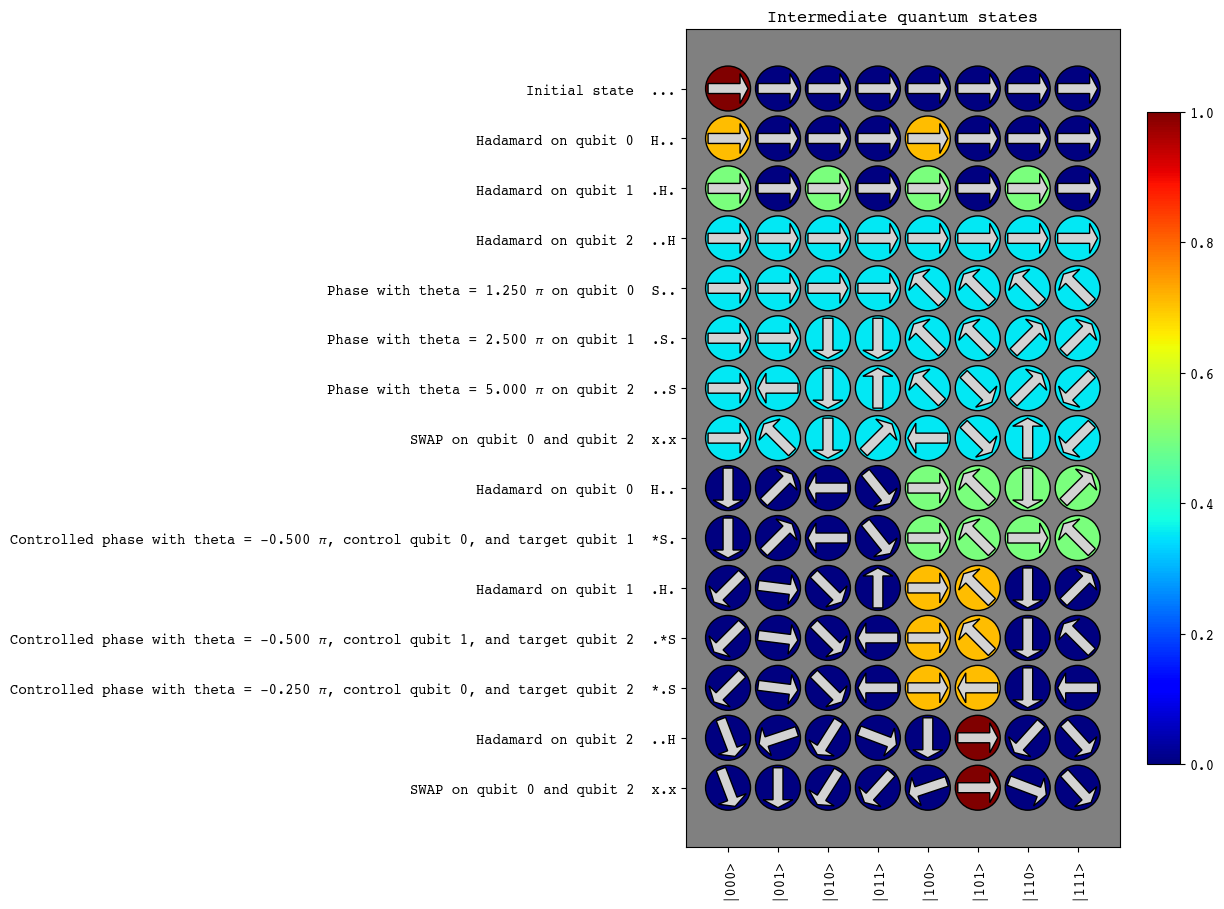

In [10]:
example_qft(3, 5, 1000)

Below, a circuit composed of $5$ qubits is created. The qubits are brought into Fourier state $|\tilde{19}\rangle$ and an inverse QFT circuit of $5$ qubits is created. The inverse QFT circuit is appended to the first $5$-qubit circuit. After applying inverse QFT and measuring, the resulting classical state will the binary represention of $19$, which is $|10011\rangle$.

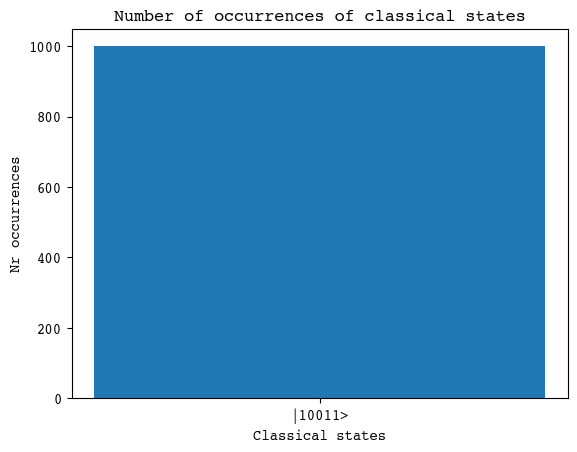

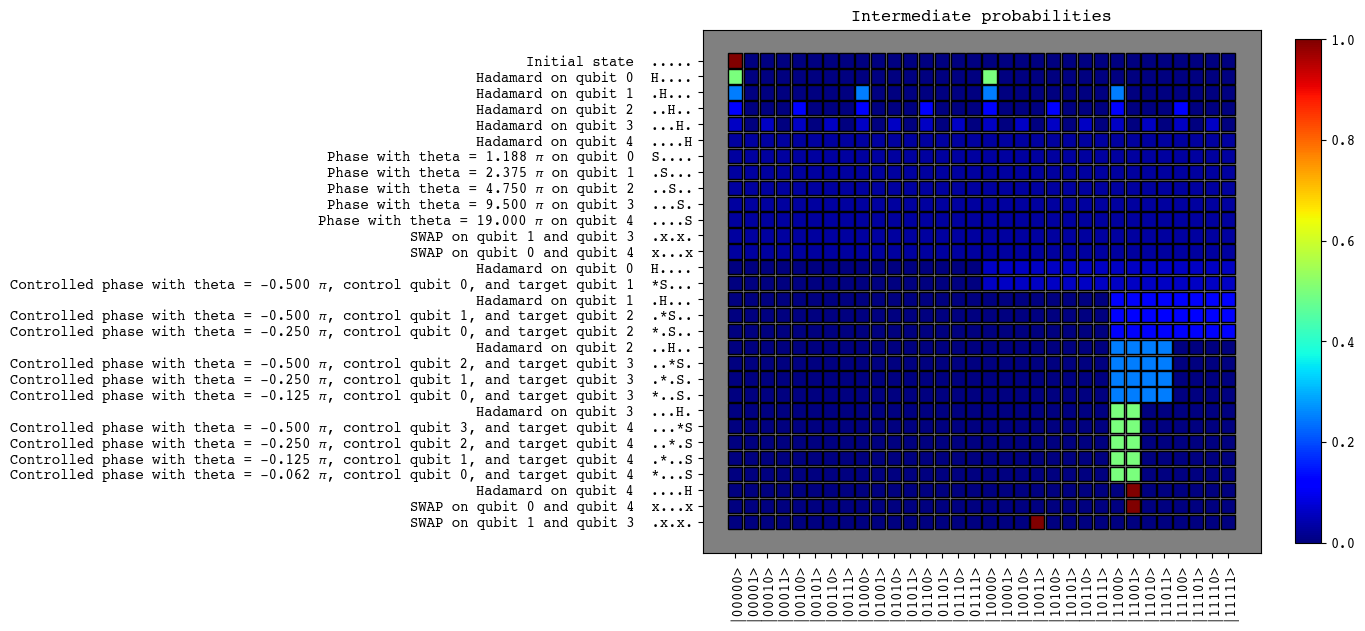

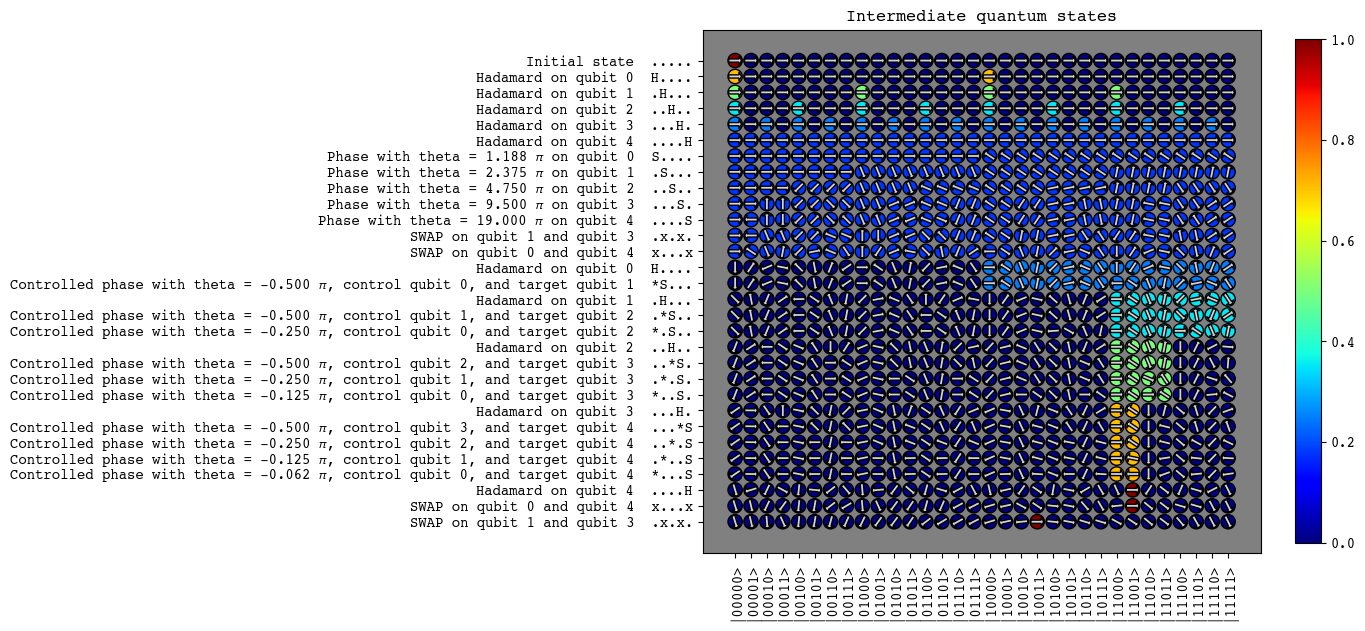

In [11]:
example_qft(5, 19, 1000)